In [ ]:
!pip install neuralforecast

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/ML_Final_Project/train.csv")
test = pd.read_csv("/content/drive/MyDrive/ML_Final_Project/test.csv")

In [ ]:
# Data preparation functions
def split_sales_data(df: pd.DataFrame, split_date: pd.Timestamp = pd.Timestamp('2012-02-15')):
    """
    Splits sales data into train and test sets based on a provided date.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    train_mask = df['Date'] < split_date
    test_mask = df['Date'] >= split_date

    df_train = df[train_mask].copy()
    df_test = df[test_mask].copy()

    return df_train, df_test

def prepare_df_for_nf(df: pd.DataFrame, is_train: bool = True) -> pd.DataFrame:
    """
    Prepare dataframe for NeuralForecast format.
    """
    df_pre = df.copy()

    # Convert Date to datetime and rename to ds
    df_pre['Date'] = pd.to_datetime(df_pre['Date'])
    df_pre.rename(columns={'Date': 'ds'}, inplace=True)

    # Rename Weekly_Sales to y in training; create dummy y in test
    if is_train:
        df_pre.rename(columns={'Weekly_Sales': 'y'}, inplace=True)
    else:
        df_pre['y'] = np.nan

    # Build unique_id per Store-Dept
    df_pre['unique_id'] = (
        df_pre['Dept'].astype(str) + '_' + df_pre['Store'].astype(str)
    )

    return df_pre

def shift_ds_by_days(df: pd.DataFrame, days: int) -> pd.DataFrame:
    """
    Returns a copy of df where the 'ds' column has been shifted by days.
    """
    df_shifted = df.copy()
    df_shifted['ds'] = df_shifted['ds'] + pd.Timedelta(days=days)
    return df_shifted

In [ ]:
# Data preparation
train_df, val_df = split_sales_data(train)

train_final = prepare_df_for_nf(train_df, is_train=True)
val_final = prepare_df_for_nf(val_df, is_train=False)
test_final = prepare_df_for_nf(test, is_train=False)

y_val = val_final['Weekly_Sales']
val_final = val_final.drop(columns=['Weekly_Sales'])

In [ ]:
# Analyze ID consistency
train_ids = set(train_final['unique_id'])
val_ids = set(val_final['unique_id'])
test_ids = set(test_final['unique_id'])

print("\n=== Unique ID Analysis ===")
print(f"Train unique_ids: {len(train_ids)}")
print(f"Val unique_ids: {len(val_ids)}")
print(f"Test unique_ids: {len(test_ids)}")

# Check for missing IDs
missing_in_val = train_ids - val_ids
missing_in_test = train_ids - test_ids
extra_in_val = val_ids - train_ids
extra_in_test = test_ids - train_ids

print(f"\nID consistency:")
print(f"Missing in val (from train): {len(missing_in_val)}")
print(f"Missing in test (from train): {len(missing_in_test)}")
print(f"Extra in val (not in train): {len(extra_in_val)}")
print(f"Extra in test (not in train): {len(extra_in_test)}")


=== Unique ID Analysis ===
Train unique_ids: 3309
Val unique_ids: 3196
Test unique_ids: 3169

ID consistency:
Missing in val (from train): 135
Missing in test (from train): 166
Extra in val (not in train): 22
Extra in test (not in train): 26


In [ ]:
# Calculate forecast parameters
forecast_horizon = len(val_final['ds'].unique())
input_size = min(forecast_horizon * 2, 104)  # Cap at ~2 years

print("\n=== Model Configuration ===")
print(f"Forecast horizon: {forecast_horizon} weeks")
print(f"Input size: {input_size} weeks")
print(f"Input/Output ratio: {input_size/forecast_horizon:.1f}x")

min_history_per_id = train_final.groupby('unique_id').size().min()
print(f"Minimum history per unique_id: {min_history_per_id} weeks")

if min_history_per_id < input_size:
    print(f"⚠️ Some series have less history ({min_history_per_id}) than input_size ({input_size})")
    print("Model will handle this with padding")



=== Model Configuration ===
Forecast horizon: 37 weeks
Input size: 74 weeks
Input/Output ratio: 2.0x
Minimum history per unique_id: 1 weeks
⚠️ Some series have less history (1) than input_size (74)
Model will handle this with padding


In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import DistributionLoss

# Initialize TFT model
tft_model = TFT(
    # Forecasting parameters
    h=forecast_horizon,
    input_size=input_size,

    # Architecture parameters
    hidden_size=128,              # Hidden dimension
    grn_activation="ELU",        # GRN activation function
    rnn_type="lstm",             # RNN type
    n_rnn_layers=4,              # Number of RNN layers
    one_rnn_initial_state=False,

    # Loss function
    loss=DistributionLoss(distribution="StudentT", level=[80, 90]),

    # Training parameters
    learning_rate=0.001,
    max_steps=2000,
    val_check_steps=100,
    early_stop_patience_steps=0,  # Disabled since we use val_size=0
    batch_size=64,

    # Regularization
    dropout=0.2,

    # Normalization and scaling
    scaler_type='robust',

    # No exogenous variables for now
    stat_exog_list=None,
    futr_exog_list=None,
    hist_exog_list=None,

    # Other parameters
    enable_progress_bar=True,
    random_seed=42
)

print("TFT model initialized:")
print(f" ✅ Forecast horizon: {tft_model.h} weeks")
print(f" ✅ Input size: {tft_model.input_size} weeks")
print(f" ✅ Hidden size: 64")  # Fixed: use the value directly instead of accessing attribute
print(f" ✅ Model type: Univariate (no exogenous variables)")

INFO:lightning_fabric.utilities.seed:Seed set to 42


TFT model initialized:
 ✅ Forecast horizon: 37 weeks
 ✅ Input size: 74 weeks
 ✅ Hidden size: 64
 ✅ Model type: Univariate (no exogenous variables)


In [ ]:
nf = NeuralForecast(models=[tft_model], freq='W')

# Train the model
nf.fit(
    df=train_final,
    val_size=0  # Using external validation
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 1.4 M  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.


In [ ]:
# Step 6: Generate Validation Predictions
print("\n=== Generating Validation Predictions ===")

# Generate predictions for validation
val_predictions = nf.predict(df=train_final)
val_predictions = shift_ds_by_days(val_predictions, 5)

print(f"Predictions generated!")
print(f"Predictions shape: {val_predictions.shape}")
print(f"Validation data shape: {val_final.shape}")

# Check prediction coverage
val_pred_ids = set(val_predictions['unique_id'])
val_target_ids = set(val_final['unique_id'])
missing_pred_ids = val_target_ids - val_pred_ids

if missing_pred_ids:
    print(f"⚠️ Missing predictions for {len(missing_pred_ids)} IDs")
else:
    print("✅ Predictions generated for all validation IDs")


=== Generating Validation Predictions ===


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions generated!
Predictions shape: (122433, 8)
Validation data shape: (109610, 6)
⚠️ Missing predictions for 22 IDs


Evaluation data shape: (109199, 4)

🎯 === Validation Performance ===
MAE: 1,776.18
RMSE: 3,905.32

📊 === Prediction Statistics ===
Actual sales — mean: 15,889.42, std: 22,100.28
Predicted sales — mean: 16,042.80, std: 22,484.77


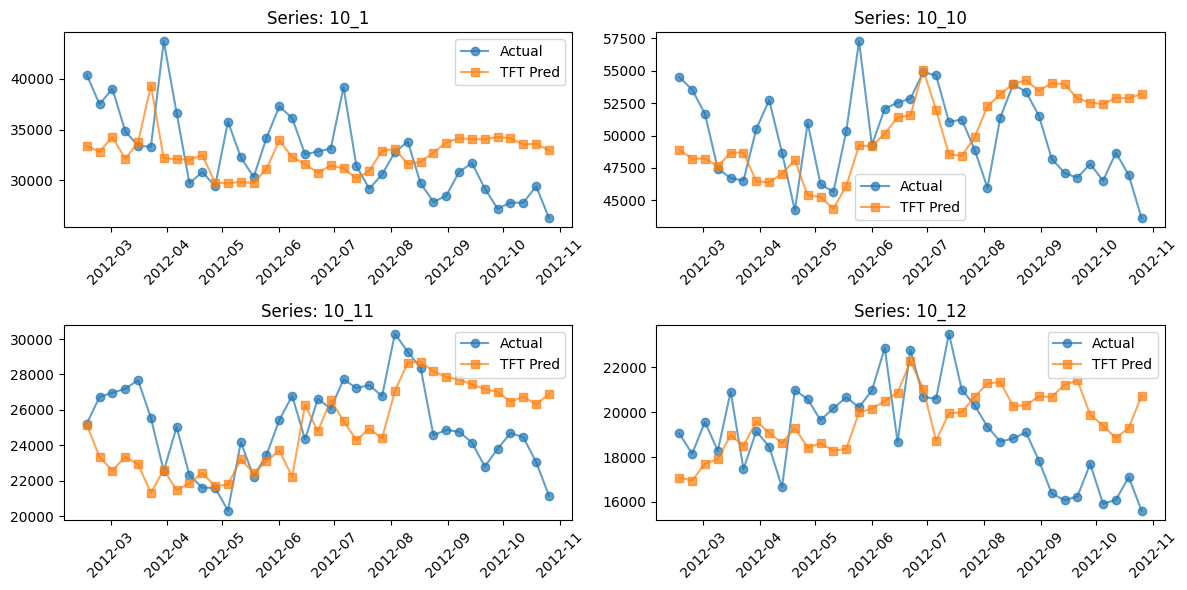

In [ ]:
#build validation targets dataframe
val_true = val_final[['unique_id', 'ds']].copy()
val_true['y'] = y_val

# Merge predictions with true targets
val_results = (
    val_predictions[['unique_id', 'ds', 'TFT']]
    .merge(val_true, on=['unique_id', 'ds'], how='inner')
)

print(f"Evaluation data shape: {val_results.shape}")

if not val_results.empty:
    # Compute metrics
    mae = mean_absolute_error(val_results['y'], val_results['TFT'])
    rmse = np.sqrt(mean_squared_error(val_results['y'], val_results['TFT']))

    print(f"\n🎯 === Validation Performance ===")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")

    # Statistics
    print(f"\n📊 === Prediction Statistics ===")
    print(f"Actual sales — mean: {val_results['y'].mean():,.2f}, std: {val_results['y'].std():,.2f}")
    print(f"Predicted sales — mean: {val_results['TFT'].mean():,.2f}, std: {val_results['TFT'].std():,.2f}")

    # Simple visualization
    plt.figure(figsize=(12, 6))

    # Sample some time series for visualization
    sample_ids = val_results['unique_id'].unique()[:4]

    for i, uid in enumerate(sample_ids):
        plt.subplot(2, 2, i+1)
        sample_data = val_results[val_results['unique_id'] == uid].sort_values('ds')

        plt.plot(sample_data['ds'], sample_data['y'], 'o-', label='Actual', alpha=0.7)
        plt.plot(sample_data['ds'], sample_data['TFT'], 's-', label='TFT Pred', alpha=0.7)
        plt.title(f'Series: {uid}')
        plt.legend()
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/ML_Final_Project/tft_validation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# For test predictions, we need to extend our training data to include validation period
# This gives the model more recent context for test predictions

# Method 1: Use the actual validation targets
print("Extending training data with validation period...")

# Create validation data with actual y values
val_with_targets = val_final.copy()
val_with_targets['y'] = y_val  # Use the stored validation targets

# Extend training data
extended_train = pd.concat([train_final, val_with_targets], ignore_index=True)

print(f"Extended training data shape: {extended_train.shape}")
print(f"Date range: {extended_train['ds'].min()} to {extended_train['ds'].max()}")

# Check for any remaining NaN values
nan_count = extended_train['y'].isna().sum()
if nan_count > 0:
    print(f"⚠️ Found {nan_count} NaN values in y column")
    # Remove rows with NaN targets
    extended_train = extended_train.dropna(subset=['y'])
    print(f"After removing NaNs: {extended_train.shape}")
else:
    print("✅ No NaN values found")

# Generate test predictions
test_predictions = nf.predict(df=extended_train)
test_predictions = shift_ds_by_days(test_predictions, 5)
print(f"Test predictions shape: {test_predictions.shape}")

Extending training data with validation period...
Extended training data shape: (421570, 6)
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
✅ No NaN values found


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Test predictions shape: (123247, 8)


In [34]:
from tqdm import tqdm
# Prepare submission data
submission_rows = []

# Process test predictions
for _, row in tqdm(test.iterrows()):
    store = str(row['Store'])
    dept = str(row['Dept'])
    date = row['Date']

    # Create ID and date string
    unique_id = f"{dept}_{store}"
    date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
    id_str = f"{store}_{dept}_{date_str}"

    # Find prediction for this combination
    pred_row = test_predictions[
        (test_predictions['unique_id'] == unique_id) &
        (test_predictions['ds'] == pd.to_datetime(date))
    ]

    if not pred_row.empty:
        # Use TFT prediction (median)
        if 'TFT-median' in pred_row.columns:
            prediction = float(pred_row['TFT-median'].iloc[0])
        else:
            prediction = float(pred_row['TFT'].iloc[0])
    else:
        # Fallback: use historical average for this store-dept combination
        hist_data = train_final[train_final['unique_id'] == unique_id]
        if not hist_data.empty:
            prediction = hist_data['y'].mean()
        else:
            prediction = 1000.0  # Global fallback

    # Ensure positive prediction
    prediction = max(0.01, prediction)

    submission_rows.append({
        'Id': id_str,
        'Weekly_Sales': round(prediction, 2)
    })

# Create submission dataframe
submission_df = pd.DataFrame(submission_rows)

print(f"Submission created:")
print(f"Total predictions: {len(submission_df)}")
print(f"Mean prediction: {submission_df['Weekly_Sales'].mean():.2f}")
print(f"Prediction range: {submission_df['Weekly_Sales'].min():.2f} - {submission_df['Weekly_Sales'].max():.2f}")

# Show sample
print(f"\nSample submission:")
print(submission_df.head(10))

# Save submission
submission_path = "/content/drive/MyDrive/ML_Final_Project/neuralforecast_tft_submission.csv"
submission_df.to_csv(submission_path, index=False)

print(f"\n✅ Submission saved to: {submission_path}")


91130it [22:39, 40.76it/s]
91135it [22:39, 39.30it/s]
91140it [22:39, 39.18it/s]
91144it [22:40, 38.56it/s]
91148it [22:40, 31.68it/s]
91152it [22:40, 32.58it/s]
91156it [22:40, 32.67it/s]
91160it [22:40, 34.44it/s]
91165it [22:40, 37.85it/s]
91170it [22:40, 39.13it/s]
91174it [22:40, 38.43it/s]
91178it [22:40, 37.34it/s]
91185it [22:41, 43.13it/s]
91193it [22:41, 52.57it/s]
91202it [22:41, 61.43it/s]
91210it [22:41, 65.64it/s]
91219it [22:41, 71.37it/s]
91227it [22:41, 66.94it/s]
91235it [22:41, 70.34it/s]
91243it [22:41, 71.43it/s]
91252it [22:41, 75.66it/s]
91261it [22:42, 78.50it/s]
91269it [22:42, 71.89it/s]
91278it [22:42, 75.62it/s]
91286it [22:42, 76.49it/s]
91295it [22:42, 78.36it/s]
91303it [22:42, 70.55it/s]
91312it [22:42, 74.48it/s]
91320it [22:42, 73.80it/s]
91329it [22:43, 76.92it/s]
91338it [22:43, 79.14it/s]
91346it [22:43, 72.40it/s]
91355it [22:43, 75.98it/s]
91363it [22:43, 77.06it/s]
91372it [22:43, 79.92it/s]
91381it [22:43, 72.55it/s]
91390it [22:43, 75.46it/s]


Submission created:
Total predictions: 115064
Mean prediction: 16527.43
Prediction range: 0.01 - 321018.56

Sample submission:
               Id  Weekly_Sales
0  1_1_2012-11-02      35869.14
1  1_1_2012-11-09      23816.21
2  1_1_2012-11-16      22250.15
3  1_1_2012-11-23      22801.20
4  1_1_2012-11-30      25100.03
5  1_1_2012-12-07      29355.99
6  1_1_2012-12-14      38910.94
7  1_1_2012-12-21      43589.10
8  1_1_2012-12-28      39237.61
9  1_1_2013-01-04      20588.00

✅ Submission saved to: /content/drive/MyDrive/ML_Final_Project/neuralforecast_tft_submission.csv


In [ ]:
!pip install dagshub mlflow

In [ ]:
import dagshub
import mlflow
dagshub.init(repo_owner='dimna21', repo_name='ML_Final_Project', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=d5af1acc-23f5-489f-a85d-17c1a96499c9&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=bcd5d02d58a0a3fa4663bee62e9287c446a6cf08f939c6419dfa882784d9ae06




Accessing as dimna21

Initialized MLflow to track repo "dimna21/ML_Final_Project"

Repository dimna21/ML_Final_Project initialized!

In [35]:
# MLflow Logging for NeuralForecast TFT Model
import mlflow
import mlflow.pytorch
import os
import json
import pickle
import numpy as np
from datetime import datetime


# Set experiment name
experiment_name = "neuralforecast-tft-walmart"
mlflow.set_experiment(experiment_name)
# Step 2: Start MLflow run
with mlflow.start_run(run_name=f"TFT-run-{datetime.now().strftime('%Y%m%d-%H%M%S')}") as run:

    print(f"\n🚀 Started MLflow run: {run.info.run_id}")

    # Step 3: Log model parameters
    print("\n📊 Logging model parameters...")

    model_params = {
        # Architecture parameters
        "model_type": "TFT",
        "library": "neuralforecast",
        "forecast_horizon": forecast_horizon,
        "input_size": input_size,
        "hidden_size": 64,
        "grn_activation": "ELU",
        "rnn_type": "lstm",
        "n_rnn_layers": 2,
        "dropout": 0.1,

        # Training parameters
        "learning_rate": 0.001,
        "max_steps": 1000,
        "val_check_steps": 100,
        "batch_size": 64,
        "scaler_type": "robust",

        # Data parameters
        "train_start_date": str(train_final['ds'].min()),
        "train_end_date": str(train_final['ds'].max()),
        "val_start_date": str(val_final['ds'].min()),
        "val_end_date": str(val_final['ds'].max()),
        "n_train_samples": len(train_final),
        "n_val_samples": len(val_final),
        "n_unique_series": len(train_final['unique_id'].unique()),
        "frequency": "W",

        # Feature information
        "exogenous_variables": "None",
        "stat_exog_list": "None",
        "futr_exog_list": "None",
        "hist_exog_list": "None",
    }

    # Log all parameters
    for param_name, param_value in model_params.items():
        mlflow.log_param(param_name, param_value)

    print(f"✅ Logged {len(model_params)} parameters")

    # Step 4: Log validation metrics
    print("\n📈 Logging validation metrics...")

    if 'mae' in locals() and 'rmse' in locals():
        validation_metrics = {
            "val_mae": mae,
            "val_rmse": rmse,
            "val_mean_actual": float(val_results['y'].mean()),
            "val_std_actual": float(val_results['y'].std()),
            "val_mean_predicted": float(val_results['TFT'].mean()),
            "val_std_predicted": float(val_results['TFT'].std()),
            "val_min_actual": float(val_results['y'].min()),
            "val_max_actual": float(val_results['y'].max()),
            "val_min_predicted": float(val_results['TFT'].min()),
            "val_max_predicted": float(val_results['TFT'].max()),
            "val_samples": len(val_results),
        }

        # Calculate additional metrics
        mape = np.mean(np.abs((val_results['y'] - val_results['TFT']) / val_results['y'])) * 100
        validation_metrics["val_mape"] = float(mape)

        # Log metrics
        for metric_name, metric_value in validation_metrics.items():
            mlflow.log_metric(metric_name, metric_value)

        print(f"✅ Logged {len(validation_metrics)} validation metrics")
        print(f"   • MAE: {mae:,.2f}")
        print(f"   • RMSE: {rmse:,.2f}")
        print(f"   • MAPE: {mape:.2f}%")
    else:
        print("⚠️ Validation metrics not available")

    # Step 5: Log submission statistics
    print("\n📋 Logging submission statistics...")

    submission_stats = {
        "test_predictions_count": len(submission_df),
        "test_mean_prediction": float(submission_df['Weekly_Sales'].mean()),
        "test_std_prediction": float(submission_df['Weekly_Sales'].std()),
        "test_min_prediction": float(submission_df['Weekly_Sales'].min()),
        "test_max_prediction": float(submission_df['Weekly_Sales'].max()),
        "test_median_prediction": float(submission_df['Weekly_Sales'].median()),
    }

    for stat_name, stat_value in submission_stats.items():
        mlflow.log_metric(stat_name, stat_value)

    print(f"✅ Logged {len(submission_stats)} submission statistics")

    # Step 6: Log model artifacts
    print("\n💾 Logging model artifacts...")

    # Create temporary directory for artifacts
    artifacts_dir = "/tmp/mlflow_artifacts"
    os.makedirs(artifacts_dir, exist_ok=True)

    # Save model configuration
    config_path = os.path.join(artifacts_dir, "model_config.json")
    with open(config_path, 'w') as f:
        json.dump(model_params, f, indent=2, default=str)
    mlflow.log_artifact(config_path, "config")

    # Save validation results
    if 'val_results' in locals():
        val_results_path = os.path.join(artifacts_dir, "validation_results.csv")
        val_results.to_csv(val_results_path, index=False)
        mlflow.log_artifact(val_results_path, "validation")

    # Save submission file
    submission_path_mlflow = os.path.join(artifacts_dir, "submission.csv")
    submission_df.to_csv(submission_path_mlflow, index=False)
    mlflow.log_artifact(submission_path_mlflow, "submission")

    # Save model summary
    model_summary = {
        "model_class": str(type(tft_model).__name__),
        "library_version": "neuralforecast",
        "creation_time": datetime.now().isoformat(),
        "forecast_horizon": forecast_horizon,
        "input_size": input_size,
        "total_parameters": "Unknown",  # NeuralForecast doesn't expose this easily
        "training_completed": True,
    }

    summary_path = os.path.join(artifacts_dir, "model_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(model_summary, f, indent=2, default=str)
    mlflow.log_artifact(summary_path, "model")

    print(f"✅ Logged model artifacts to {artifacts_dir}")

    # Step 7: Log training plots (if they exist)
    print("\n📊 Logging visualizations...")

    # Check if plots were saved
    plot_files = [
        '/content/drive/MyDrive/ML_Final_Project/tft_validation_results.png',
        '/content/drive/MyDrive/ML_Final_Project/prediction_distribution.png'
    ]

    for plot_file in plot_files:
        if os.path.exists(plot_file):
            mlflow.log_artifact(plot_file, "plots")
            print(f"✅ Logged plot: {os.path.basename(plot_file)}")

    # Step 8: Log dataset information
    print("\n📊 Logging dataset information...")

    dataset_info = {
        "dataset_name": "Walmart Sales Forecasting",
        "train_size": len(train_final),
        "validation_size": len(val_final),
        "test_size": len(test_final),
        "n_stores": len(train_final['Store'].unique()) if 'Store' in train_final.columns else "Unknown",
        "n_departments": len(train_final['Dept'].unique()) if 'Dept' in train_final.columns else "Unknown",
        "date_range_days": (pd.to_datetime(train_final['ds'].max()) - pd.to_datetime(train_final['ds'].min())).days,
        "split_date": "2012-02-15",
    }

    for info_name, info_value in dataset_info.items():
        mlflow.log_param(f"data_{info_name}", info_value)

    print(f"✅ Logged {len(dataset_info)} dataset parameters")


🚀 Started MLflow run: ba9d3a18c1a74adeb1e63e1f0c7c528a

📊 Logging model parameters...
✅ Logged 26 parameters

📈 Logging validation metrics...
✅ Logged 12 validation metrics
   • MAE: 1,776.18
   • RMSE: 3,905.32
   • MAPE: inf%

📋 Logging submission statistics...
✅ Logged 6 submission statistics

💾 Logging model artifacts...
✅ Logged model artifacts to /tmp/mlflow_artifacts

📊 Logging visualizations...
✅ Logged plot: tft_validation_results.png

📊 Logging dataset information...
✅ Logged 8 dataset parameters
🏃 View run TFT-run-20250731-190711 at: https://dagshub.com/dimna21/ML_Final_Project.mlflow/#/experiments/12/runs/ba9d3a18c1a74adeb1e63e1f0c7c528a
🧪 View experiment at: https://dagshub.com/dimna21/ML_Final_Project.mlflow/#/experiments/12
